In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [2]:
import warnings
warnings.simplefilter("ignore") 
import logging
logging.basicConfig(level=logging.ERROR)

In [31]:
from kinoml.datasets.chembl import ChEMBLDatasetProvider
chembl = ChEMBLDatasetProvider.from_source() #sample=20000)

100%|██████████| 203752/203752 [00:07<00:00, 26913.63it/s]


In [32]:
chembl

<ChEMBLDatasetProvider with 203752 IC50Measurement measurements and 162839 systems>

In [33]:
df = chembl.to_dataframe()
df

,Systems,n_components,Measurement,MeasurementType
0,P00533 & Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F...,2,41.00,IC50Measurement
1,P35968 & Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F...,2,16500.00,IC50Measurement
2,P00533 & Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)...,2,170.00,IC50Measurement
3,P06239 & Nc1ncnc2c1c(-c1cccc(Oc3ccccc3)c1)cn2C...,2,140.00,IC50Measurement
4,P06239 & Nc1ncnc2c1c(-c1cccc(Oc3ccccc3)c1)cn2C...,2,1180.00,IC50Measurement
...,...,...,...,...
203747,P42345 & CC(C)n1nc(-c2cc3cc(O)ccc3[nH]2)c2c(N)...,2,3.00,KdMeasurement
203748,P42345 & CO[C@H]1CC[C@H](N2C(=O)CNc3ncc(-c4ccc...,2,28.00,KdMeasurement
203749,P42345 & CNC(=O)c1cccc(-c2ccc3c(N4CCOC[C@@H]4C...,2,0.14,KdMeasurement
203750,P42345 & CO[C@H]1C[C@@H]2CC[C@@H](C)[C@@](O)(O...,2,0.60,KdMeasurement


In [34]:
print("Measurements:", len(chembl.measurements))
print("Systems:", len(chembl.systems))
print("Proteins:", len(set([s.protein for s in chembl.systems])))
print("Ligands:",len(set([s.ligand.name for s in chembl.systems])))

Measurements: 203752
Systems: 162839
Proteins: 422
Ligands: 103302


Having this many ligands (compared to PKIS2) makes this dataset take much more memory and longer (~10 mins) to initialize!

In [46]:
from kinoml.features.ligand import SmilesToLigandFeaturizer, MorganFingerprintFeaturizer
from kinoml.features.protein import AminoAcidCompositionFeaturizer
from kinoml.features.core import HashFeaturizer, Concatenated, Pipeline

morgan_featurizer = Pipeline([SmilesToLigandFeaturizer(), MorganFingerprintFeaturizer(nbits=1024, radius=2)])
composition_featurizer = AminoAcidCompositionFeaturizer()
concat_featurizers = Concatenated([morgan_featurizer, composition_featurizer], axis=0)

You can prefeaturize everything before the loop with this cell:

In [8]:
# %%time
# chembl.featurize(concat_featurizers)

Or delay the featurization until the systems are needed by passing the featurizer to the `to_pytorch` constructor. We will use this strategy!

## Temporary workaround

To debug the loss problem, we will only consider one protein for now:

In [47]:
from collections import Counter
counts = Counter([s.system.protein.name for s in chembl.measurements])
sorted_counts = sorted(counts.items(), key=lambda kv: kv[1], reverse=True)[:5]
sorted_counts

[('P35968', 10035),
 ('P00533', 8582),
 ('O60674-O60674', 5659),
 ('P15056', 5248),
 ('Q16539', 5057)]

In [48]:
from kinoml.core.measurements import IC50Measurement
measurements = []
for ms in chembl.measurements:
    if ms.system.protein.name == sorted_counts[0][0] and isinstance(ms, IC50Measurement):
        measurements.append(ms)
len(measurements)

9629

In [49]:
from kinoml.datasets.chembl import _SingleTypeChEMBLDatasetProvider
subchembl = ChEMBLDatasetProvider([_SingleTypeChEMBLDatasetProvider(measurements)])

In [50]:
subchembl

<ChEMBLDatasetProvider with 9629 IC50Measurement measurements and 7426 systems>

In [20]:
# End of temporary workaround; subchembl used from now on, instead of chembl

In [53]:
datasets = subchembl.to_pytorch(featurizer=concat_featurizers, minus_log10=False)
datasets

In [54]:
observation_models = subchembl.observation_models(backend="pytorch", minus_log10=False)
observation_models

[<function kinoml.core.measurements.IC50Measurement._observation_model_pytorch(dG_over_KT, substrate_conc=1e-06, michaelis_constant=1, inhibitor_conc=1e-06, **kwargs)>]

In [58]:
import torch
from kinoml.ml.torch_models import NeuralNetworkRegression
from tqdm.auto import trange, tqdm
from kinoml.core.measurements import null_observation_model

# Use DataLoader for minibatches
datasets = subchembl.to_pytorch(featurizer=concat_featurizers, minus_log10=False)
loaders = [dataset.as_dataloader(batch_size=64) for dataset in datasets]

# precompute input size
input_size = datasets[0].estimate_input_size()
model = NeuralNetworkRegression(input_size=input_size[0])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = torch.nn.MSELoss() # Mean squared error

nb_epoch = 100
loss_timeseries = []
ys = []
range_epochs = trange(nb_epoch, desc="Epochs (+ featurization...)")
for epoch in range_epochs:
    # Single cumulative loss / or loss per loader? look into this!
    cumulative_loss = torch.zeros(len(loaders), dtype=torch.float64)
    for i, loader in enumerate(loaders):
        for x, y in loader:
            # Clear gradients
            optimizer.zero_grad()
            
            # Obtain model prediction given model input
            delta_g = model(x)

            # with observation model
            prediction = loader.dataset.observation_model(delta_g)
            
            loss = loss_function(-torch.log10(prediction), -torch.log10(y))
            ys.append([-torch.log10(prediction), -torch.log10(y)])
            
            # Obtain loss for the predicted output
            # if cumulative loss is global, change this i to 0, or viceversa
            cumulative_loss[0] += loss.item()

            # Gradients w.r.t. parameters
            loss.backward()
            
            # Optimizer
            optimizer.step()
            
    loss_timeseries.append(cumulative_loss[0])
    range_epochs.set_description(f"Epochs (loss={loss_timeseries[-1]:.2e})")

KeyboardInterrupt: 

In [59]:
from matplotlib import pyplot as plt

[(-5, 5), (-5, 5)]

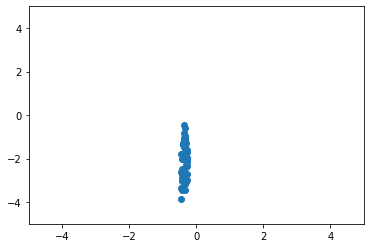

In [67]:
i = 4
fig, ax = plt.subplots()
ax.scatter(ys[i][0].detach().numpy(), ys[i][1].detach().numpy())
ax.set(xlim=(-5, +5), ylim=(-5, +5))